# Import statements

Training data converted to dataframe

In [1]:
import pandas as pd
df=pd.read_csv('/home/ritwik/Downloads/submission/NLP problem/dataset/Subtask-A-master/V1.4_Training.csv',header=None)

Testing data converted to dataframe

In [2]:
df_test=pd.read_csv('/home/ritwik/Downloads/submission/NLP problem/dataset/Subtask-A-master/SubtaskA_Trial_Test.csv',encoding="latin-1",header=None)

Importing Libraries

In [3]:
import num2words
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
from nltk.stem.porter import *
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ritwik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Renaming columns of training dataframe 

In [4]:
df=df.rename(columns={0:'serial',1:'Sentence',2:'Suggestion_or_not'})

# Preprocessing Text

Lemmatization and stopword removal has been done

In [5]:
def preprocess_text(text):
    lemmatizer=WordNetLemmatizer()
    text=text.lower()
    token1=tokenizer.tokenize(text)
    token=[]
    for x in token1:
        if x not in stop_words:
            token.append(x)
            #stemmed = [stemmer.stem(tokens) ]
    lemmatiz=[lemmatizer.lemmatize(tokens) for tokens in token]
    return lemmatiz

Creating sentences in the form of paragraphs

In [6]:
para=[[] for i in range(len(df))]
for i in range(len(df)):
    text=df.iloc[i][1]
    text=str(text)
    para[i]=preprocess_text(text)

# Training

Training process is used to create four dictionaries. Dict1 is the name given to the dictionary that stores the priors. Dict2 stores the vocabulary of the training data and which different words occur in a document.Dict3 is used to calculate the posterior probabilities. Dict4 is calculating the term frequency and inverse document frequency of different words

In [7]:
def train_corpus(df):
    dict1=dict()
    dict2=dict()
    dict3=dict()
    dict4=dict()
    s=set(df.iloc[:,2].tolist())
    for i in s:
        dict1[i]=0
        dict2[i]=set()
        dict4[i]=0
    for i in range(len(df)):
        dict1[df.iloc[i][2]]=dict1[df.iloc[i][2]]+1
        lemmatiz=preprocess_text(df.iloc[i][1])
        for j in lemmatiz:
            dict2[df.iloc[i][2]].add(j)
            dict4[df.iloc[i][2]]=dict4[df.iloc[i][2]]+1
            if j in dict3:
                if df.iloc[i][2] in dict3[j]:
                    dict3[j][df.iloc[i][2]]=dict3[j][df.iloc[i][2]]+1
                else:
                     dict3[j][df.iloc[i][2]]=1
            else:
                dict3[j]=dict()
                dict3[j][df.iloc[i][2]]=1
    #applying smoothing
    for classes in dict1:
        dict1[classes]=dict1[classes]/len(df)
    return dict1,dict2,dict3,dict4

# Prediction

Predict function is used to assign the sentence to the class having maximum value by applying the formula for naive bayes

In [8]:
import math
def predict(df,df_test,dict1,dict2,dict3,dict4):
    lab=set(df.iloc[:,2].tolist())
    prediction=[]
    for i in range(len(df_test)):
        maxval=-math.inf
        index=''
        lemmatiz=preprocess_text(df_test.iloc[i][1])
        for x in lab:
            
            prob=0
            for word in lemmatiz:
                       
                if word in dict3:
                    if x in dict3[word]:
                        prob1=math.log((dict3[word][x]+1)/(len(dict2[x])+dict4[x]))
                    else:
                        prob1=math.log(1/(len(dict2[x])+dict4[x]))
                else:
                    prob1=math.log(1/(len(dict2[x])+dict4[x]))
                prob=prob+prob1
                
            prob=prob+math.log(dict1[x])
            
            if prob>maxval:
                maxval=prob
                index=x
        prediction.append(index)
    return prediction

# Cross Validation

k-fold cross validation has been performed on the training data for selecting the best fold on which training must be done. The dataframe has been divided into k equal folds. One fold in each iteration went for testing and every other fold became training folds. The fold with the best testing accuracy has been selected and would be used for training the data

In [9]:
def cross_validate(df_train,k):
    acc=0
    for i in range(k):
        x=int((i/k)*len(df_train))
        y=int(((i+1)/k)*len(df_train))
        test_df=df_train.iloc[x:y]
        train_df = df_train[~df_train.index.isin(test_df.index)]
        prior_dict,vocab_classes,post_dict,tokens_classes=train_corpus(train_df)
        pre=predict(train_df,test_df,prior_dict,vocab_classes,post_dict,tokens_classes)
        truelabels=test_df.iloc[:, 2].tolist()
        count=0
        for i in range(len(pre)):
            if pre[i]==truelabels[i]:
                count=count+1
        a=count/len(pre)
        if a>acc:
            acc=a
            return_df=train_df
    
    return return_df

        

# Calling functions

In [10]:
train=cross_validate(df,5)

In [11]:
prior_dict,vocab_classes,post_dict,tokens_classes=train_corpus(train)

# Visualization

## Prior probabilities

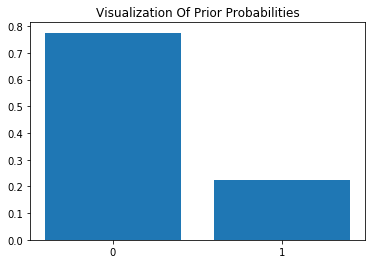

In [13]:
import matplotlib.pyplot as plt
plt.bar(range(len(prior_dict)), list(prior_dict.values()), align='center')
plt.xticks(range(len(prior_dict)), list(prior_dict.keys()))
plt.title('Visualization Of Prior Probabilities')
plt.show()

## Frequency of words

In [14]:
sorted_list=sorted(tokens_classes.values(),reverse=True)
post=dict()
c=0
for x in sorted_list:
    c=c+1
    if c<=10:
        for key, value in tokens_classes.items() :
            if value==x:
                post[key]=value
                break

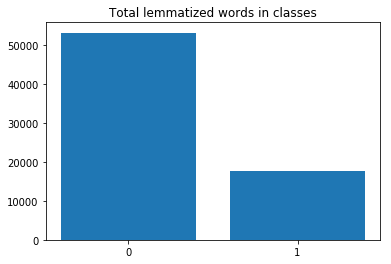

In [15]:
import matplotlib.pyplot as plt
plt.bar(range(len(post)), list(post.values()), align='center')
plt.xticks(range(len(post)), list(post.keys()))
plt.title('Total lemmatized words in classes')
plt.show()

## Frequency of words for 0 label

In [16]:
newdict=dict()
for words in post_dict:
    for labels in post_dict[words]:
        if labels not in newdict:
            newdict[labels]=dict()       
        newdict[labels][words]=post_dict[words][labels]

In [17]:
sorted_list=sorted(newdict[0].values(),reverse=True)
post=dict()
c=0
print(len(newdict[0]))
for x in sorted_list:
    c=c+1
    if c<=10:
        for key, value in newdict[0].items() :
            if value==x:
                post[key]=value
                break

7727


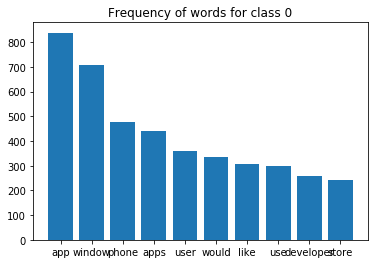

In [18]:
import matplotlib.pyplot as plt
plt.bar(range(len(post)), list(post.values()), align='center')
plt.xticks(range(len(post)), list(post.keys()))
plt.title('Frequency of words for class 0')
plt.show()

In [ ]:
pre=predict(train,df_test,prior_dict,vocab_classes,post_dict,tokens_classes)

In [ ]:
print(len(pre))

In [ ]:
result=[[] for i in range(len(pre))]
for i in range(len(pre)):
    result[i].append(df_test.iloc[i][0])
    result[i].append(df_test.iloc[i][1])
    result[i].append(pre[i])

In [ ]:
# result_df=pd.DataFrame(result)
# result_df.to_csv('Ritwik_Mitra.csv')

# Accuracy

In [ ]:
# pre=predict(train,df_test,prior_dict,vocab_classes,post_dict,tokens_classes)

# truelabels=df_test.iloc[:, 2].tolist()

# count=0
# for i in range(len(pre)):
#     if pre[i]==truelabels[i]:
#         count=count+1
# print(count/len(pre))

# Writing predictions to csv file

In [ ]:
# with open('Result_Naive_Bayes.csv', "w") as outfile:
#     for entries in pre:
#         outfile.write(str(entries))
#         outfile.write("\n")